In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split


Upload dos datasets de treino e de testes obtidos no **tarefa_2_get_data**:

In [2]:
data_treino = pd.read_csv('dataset_treino.csv', na_filter=False)
data_teste = pd.read_csv('dataset_teste.csv', na_filter=False)

Damos drop da coluna Data:

In [3]:
data_treino.drop(columns=['Data'], inplace=True)
data_teste.drop(columns=['Data'], inplace=True)

One hot encoding do atributo weather_description no dataset de treino e de teste:

In [4]:
lb = LabelBinarizer()
lb_results = lb.fit_transform(data_treino['weather_description'])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)

data_treino = pd.concat([data_treino, lb_results_df], axis=1)
data_treino.drop(columns=['weather_description'], inplace=True)
#data_treino.info()

In [5]:
lb = LabelBinarizer()
lb_results = lb.fit_transform(data_teste['weather_description'])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)

data_teste = pd.concat([data_teste, lb_results_df], axis=1)
data_teste.drop(columns=['weather_description'], inplace=True)


Feature Engineering: criamos os atributos pressure_level, rolling_avg_temp, temp_humidity_interaction e wind_rain_interaction:

In [21]:
data_treino['pressure_level'] = pd.cut(data_treino['pressure'], bins=[0, 1000, 1020, 1050], labels=['low', 'medium', 'high'])
data_teste['pressure_level'] = pd.cut(data_teste['pressure'], bins=[0, 1000, 1020, 1050], labels=['low', 'medium', 'high'])

data_treino['rolling_avg_temp'] = data_treino['temp_max'].rolling(window=3).mean()
data_teste['rolling_avg_temp'] = data_teste['temp_max'].rolling(window=3).mean()
data_treino['rolling_avg_temp'].fillna(data_treino['temp_max'], inplace=True)
data_teste['rolling_avg_temp'].fillna(data_teste['temp_max'], inplace=True)


data_treino['temp_humidity_interaction'] = data_treino['temp_max'] * data_treino['humidity']
data_teste['temp_humidity_interaction'] = data_teste['temp_max'] * data_teste['humidity']

data_treino['wind_rain_interaction'] = data_treino['wind_speed'] * data_treino['rain_1h']
data_teste['wind_rain_interaction'] = data_teste['wind_speed'] * data_teste['rain_1h']

data_treino.head()

,Ano_x,Mês_x,Dia_x,Hora_x,Normal (kWh),Horário Económico (kWh),Autoconsumo (kWh),Injeção na rede (kWh),Ano_y,Mês_y,...,overcast clouds,scattered clouds,sky is clear,rolling_avg_temp,temp_humidity_interaction,wind_rain_interaction,pressure__low,pressure__medium,pressure__high,pressure_level
0,2021,9,29,0,0.0,0.0,0.0,None,2021,9,...,1,0,0,14.040000,1137.239997,0.0,False,False,True,high
1,2021,9,29,1,0.0,0.0,0.0,None,2021,9,...,1,0,0,13.900000,1139.799969,0.0,False,False,True,high
2,2021,9,29,2,0.0,0.0,0.0,None,2021,9,...,1,0,0,13.790000,1128.120026,0.0,False,False,True,high
3,2021,9,29,3,0.0,0.0,0.0,None,2021,9,...,1,0,0,13.420000,1099.050026,0.0,False,False,True,high
4,2021,9,29,4,0.0,0.0,0.0,None,2021,9,...,1,0,0,13.096667,1111.980026,0.0,False,False,True,high


one-hot encoding do pressure_level:

In [7]:

pressure_level_dummies_train = pd.get_dummies(data_treino['pressure_level'], prefix='pressure_')

data_treino = pd.concat([data_treino, pressure_level_dummies_train], axis=1)

data_treino = data_treino.drop('pressure_level', axis=1)




In [8]:

pressure_level_dummies_test = pd.get_dummies(data_teste['pressure_level'], prefix='pressure_')

data_teste = pd.concat([data_teste, pressure_level_dummies_test], axis=1)

data_teste = data_teste.drop('pressure_level', axis=1)

In [9]:
float_features = data_treino.select_dtypes(include='float')
int_features = data_treino.select_dtypes(include='int')

data_treino[float_features.columns] = data_treino[float_features.columns].astype(np.float32)
data_treino[int_features.columns] = data_treino[int_features.columns].astype(np.int32)
#data_treino.info()

In [10]:
float_features = data_teste.select_dtypes(include='float')
int_features = data_teste.select_dtypes(include='int')

data_teste[float_features.columns] = data_teste[float_features.columns].astype(np.float32)
data_teste[int_features.columns] = data_teste[int_features.columns].astype(np.int32)
#data_teste.info()

In [11]:
from sklearn.preprocessing import MinMaxScaler
data_treino_normalize = data_treino.copy()
data_teste_normalize = data_teste.copy()

X_scale = data_treino_normalize.drop(columns=['Injeção na rede (kWh)'])

scaler_X = MinMaxScaler(feature_range=(0,1)).fit(X_scale)
scaler_y = MinMaxScaler(feature_range=(0,1)).fit(data_teste_normalize)
X_scale = pd.DataFrame(scaler_X.transform(X_scale[X_scale.columns]), columns=X_scale.columns)
data_teste_normalize = pd.DataFrame(scaler_y.transform(data_teste_normalize[data_teste_normalize.columns]), columns=data_teste_normalize.columns)

data_treino_normalize = pd.concat([X_scale, data_treino_normalize['Injeção na rede (kWh)']], axis=1)

#data_treino_normalize.head()

In [12]:
float_features_normalize = data_treino_normalize.select_dtypes(include='float')

data_treino_normalize[float_features_normalize.columns] = data_treino_normalize[float_features_normalize.columns].astype(np.float32)
#data_treino_normalize.info()

In [13]:
float_features_normalize = data_teste_normalize.select_dtypes(include='float')

data_teste_normalize[float_features_normalize.columns] = data_teste_normalize[float_features_normalize.columns].astype(np.float32)
#data_teste_normalize.info()

In [14]:
X_treino = data_treino.drop(columns=['Injeção na rede (kWh)'])
y_treino = data_treino['Injeção na rede (kWh)']

X_teste = data_teste


X_treino_normalize = data_treino_normalize.drop(columns=['Injeção na rede (kWh)'])
y_treino_normalize = data_treino_normalize['Injeção na rede (kWh)']

X_teste_normalize = data_teste_normalize

In [15]:

X_train, X_test, y_train, y_test = train_test_split(X_treino, y_treino, test_size=0.25, random_state=2023, stratify=y_treino)
X_train_normalize, X_test_normalize, y_train_normalize, y_test_normalize = train_test_split(X_treino_normalize, y_treino_normalize, test_size=0.25, random_state=2023, stratify=y_treino_normalize)

In [16]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder


xgb = XGBClassifier(random_state=2023, objective='multi:softprob', num_class=5)

# label_encoder = LabelEncoder()
# y_train_normalize = label_encoder.fit_transform(y_train_normalize)
# y_test_normalize = label_encoder.fit_transform(y_test_normalize)

label_mapping = {'None': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}
y_train_normalize = y_train_normalize.replace(label_mapping)
y_test_normalize = y_test_normalize.replace(label_mapping)

Usamos Random Search:

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[CV 1/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=800;, score=0.875 total time=  29.4s
[CV 2/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=800;, score=0.880 total time=  25.8s
[CV 3/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=800;, score=0.870 total time=  26.7s
[CV 4/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=800;, score=0.889 total time=  25.1s
[CV 5/5] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.2, max_depth=3, min_child_weight=2, n_estimators=800;, score=0.864 total time=  25.8s
[CV 1/5] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=400;, score=0.880 total time=  11.8s
[CV 2/5] END colsample_bytree=1.0, gamma=0.1, learning_rate=0.2, max_depth=4, min_child_weight=3, n_estimators=4

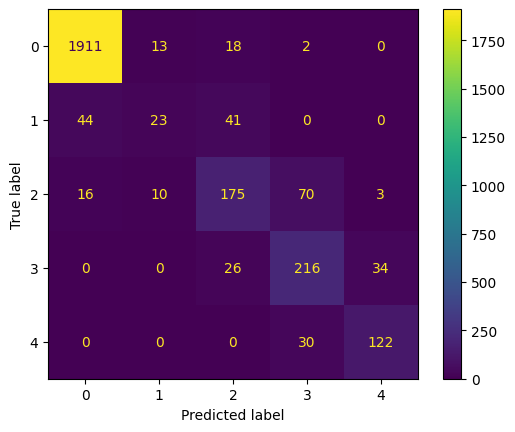

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score


# Define the parameter grid
param_dist = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [400, 600, 800],
    'max_depth': [3, 4, 5, 6],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 2, 3],
    'colsample_bytree': [0.8, 1.0],
}

# Use RandomizedSearchCV instead of GridSearchCV
random_searchXGB = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=10,  # Adjust the number of iterations based on your resources
    scoring=make_scorer(accuracy_score),  # Change this to your desired metric
    cv=5,
    refit=True,
    verbose=3,
    random_state=2023
)

# Fit the model
random_searchXGB.fit(X_train_normalize, y_train_normalize)

# Get the best estimator and its hyperparameters
XGB_best  = random_searchXGB.best_estimator_
best_params = random_searchXGB.best_params_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

# Predictions and evaluation
grid_predictionXGB = random_searchXGB.predict(X_test_normalize)
print(classification_report(y_test_normalize, grid_predictionXGB))
ConfusionMatrixDisplay.from_estimator(XGB_best, X_test_normalize, y_test_normalize)
plt.show()

In [18]:
# label_encoder = LabelEncoder()
# y_treino_normalize = label_encoder.fit_transform(y_treino_normalize)

label_mapping = {'None': 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}
y_treino_normalize = y_treino_normalize.replace(label_mapping)

XGB_best.fit(X_treino_normalize, y_treino_normalize)
predictionXGB = XGB_best.predict(X_teste_normalize)

inverted_label_mapping = {0: 'None', 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'}
predictionXGB = np.vectorize(inverted_label_mapping.get)(predictionXGB)

# predictionXGB = label_encoder.inverse_transform(predictionXGB)

In [19]:
with open('results.csv', 'w') as results:
    results.write('RowId,Result\n')
    i = 1
    for p in predictionXGB:
        results.write(f'{i},{p}\n')
        i+=1